<a href="https://colab.research.google.com/github/ritwiks9635/Object_Recognition_And_Detection-/blob/main/Face_Keypoints_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Face Keypoints Detection from Scratch in Pytorch**

In [1]:
import torch
from torchvision import models
import pandas as pd
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import glob
import os
import cv2
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchsummary import summary
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [3]:
# downloading the data

!git clone https://github.com/udacity/P1_Facial_Keypoints.git
!cd P1_Facial_Keypoints
root_dir = 'P1_Facial_Keypoints/data/training/'
all_img_paths = glob.glob(os.path.join(root_dir, '*.jpg'))
data = pd.read_csv('P1_Facial_Keypoints/data/training_frames_keypoints.csv')

Cloning into 'P1_Facial_Keypoints'...
remote: Enumerating objects: 6049, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 6049 (delta 3), reused 7 (delta 2), pack-reused 6038
Receiving objects: 100% (6049/6049), 329.53 MiB | 21.87 MiB/s, done.
Resolving deltas: 100% (156/156), done.
Updating files: 100% (5805/5805), done.


In [4]:
data.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,126,127,128,129,130,131,132,133,134,135
0,Luis_Fonsi_21.jpg,45.0,98.0,47.0,106.0,49.0,110.0,53.0,119.0,56.0,...,83.0,119.0,90.0,117.0,83.0,119.0,81.0,122.0,77.0,122.0
1,Lincoln_Chafee_52.jpg,41.0,83.0,43.0,91.0,45.0,100.0,47.0,108.0,51.0,...,85.0,122.0,94.0,120.0,85.0,122.0,83.0,122.0,79.0,122.0
2,Valerie_Harper_30.jpg,56.0,69.0,56.0,77.0,56.0,86.0,56.0,94.0,58.0,...,79.0,105.0,86.0,108.0,77.0,105.0,75.0,105.0,73.0,105.0
3,Angelo_Reyes_22.jpg,61.0,80.0,58.0,95.0,58.0,108.0,58.0,120.0,58.0,...,98.0,136.0,107.0,139.0,95.0,139.0,91.0,139.0,85.0,136.0
4,Kristen_Breitweiser_11.jpg,58.0,94.0,58.0,104.0,60.0,113.0,62.0,121.0,67.0,...,92.0,117.0,103.0,118.0,92.0,120.0,88.0,122.0,84.0,122.0


In [5]:
data.loc[0][2:][::2]

1       98.0
3      106.0
5      110.0
7      119.0
9      125.0
       ...  
127    119.0
129    117.0
131    119.0
133    122.0
135    122.0
Name: 0, Length: 68, dtype: object

In [6]:
print(data.shape)
len(data)

(3462, 137)


3462

In [7]:
doc = data.iloc[0]

**in this dataset, first column correpond to image name. Starting from second column, even columns correspond to X-axis of the facial points and odd columns correpsond to y-axis of the points**

(196, 157, 3)
(196, 157, 3)


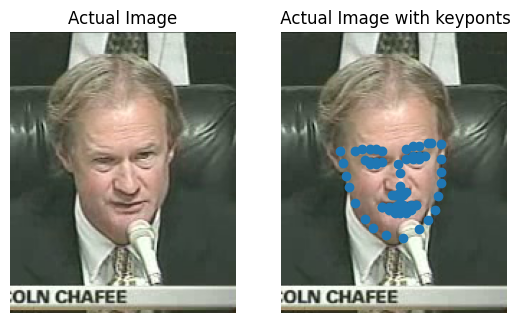

In [8]:
img_path = os.path.join(root_dir, "Lincoln_Chafee_52.jpg")
image = cv2.imread(img_path)
print(image.shape)
# converting BGR to RGB
image = image[:,:,::-1]
print(image.shape)

x_points = data.iloc[1][1:][::2]
y_points = data.iloc[1][2:][::2]

plt.subplot(121)
plt.imshow(image)
plt.title("Actual Image")
plt.axis("off")

plt.subplot(122)
plt.imshow(image)
plt.scatter(list(x_points), list(y_points))
plt.title(" Actual Image with keyponts")
plt.axis("off")
plt.show()

In [28]:
class FaceDataset(Dataset):
    def __init__(self, df):
        super().__init__()
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])
        self.df = df

    def __getitem__(self, idx):
        doc = self.df.iloc[idx]
        img_name = doc[0]
        img_path = os.path.join(root_dir, img_name)
        images = cv2.imread(img_path)
        #images = all_image[:, :, ::-1]
        images = images / 255.0
        images = self.preprocess_img(images)

        x_points = doc[1:][::2]
        y_points = doc[2:][::2]
        # scaling the facial points with respective image_dim

        x_points_s = list(x_points / images.shape[1])
        y_points_s = list(y_points / images.shape[0])

        points = x_points_s + y_points_s

        return images.to(device), torch.tensor(points).to(device)

    def __len__(self):
        return len(self.df)


    def preprocess_img(self, image):
        image = cv2.resize(image, (224, 224))
        image = torch.tensor(image).permute(2, 0, 1)
        image = self.normalize(image).float()
        return image

    def load_img(self, idx):
        doc = self.df.iloc[idx]
        img_name = doc[0]
        img = cv2.imread(os.path.join(root_dir, img_name))
        return img

In [10]:
train_df, test_df = train_test_split(data, test_size = 0.2)

In [29]:
train_dataset = FaceDataset(train_df)
test_dataset = FaceDataset(test_df)

In [12]:
train_loader = DataLoader(train_dataset, batch_size = 8, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 8, shuffle = True)

In [13]:
for img, point in train_loader:
    print(img.shape)
    print(point.shape)
    break

torch.Size([8, 3, 224, 224])
torch.Size([8, 136])


In [14]:
model = models.vgg16(pretrained = True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 142MB/s]


In [15]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [16]:
for params in model.parameters():
    params.requires_grad = False

In [17]:
pool_layers = nn.Sequential(
    nn.Conv2d(512, 512, kernel_size = 3, padding = "same"),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 2, stride = 2),
    nn.Conv2d(512, 50, kernel_size = 3, padding = "same"),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 2, stride = 2),
    nn.AdaptiveAvgPool2d(output_size = (8, 8))
    )

model.avgpool = pool_layers

final_layers = nn.Sequential(
    nn.Linear(3200, 300),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(300, 136),
    nn.Sigmoid()
    )

model.classifier = final_layers

In [18]:
model = model.to(device)

In [19]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [20]:
summary(model, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [21]:
def get_essentials():
    loss_fn = nn.L1Loss()
    optimizer = optim.Adam(model.parameters(), lr = 1e-3)
    return loss_fn, optimizer

In [23]:
def train_batch(data, model, loss_fun, optimizer):
  model.train()
  img, true_points = data
  pred_points = model(img)
  loss_val = loss_fun(pred_points, true_points)
  loss_val.backward()
  optimizer.step()
  optimizer.zero_grad()
  return loss_val.item()

@torch.no_grad()
def val_batch(data, model, loss_fun, optimizer):
  model.eval()
  img, true_points = data
  pred_points = model(img)
  loss_val = loss_fun(pred_points, true_points)
  return loss_val.item()

In [31]:
epochs = 100

loss_fn, optimizer = get_essentials()

In [32]:
train_epoch, val_epoch = [], []
for epoch in tqdm(range(epochs)):
  train_batch_losses, val_batch_losses = [], []

  for data in train_loader:
    train_batch_loss = train_batch(data, model, loss_fn, optimizer)
    train_batch_losses.append(train_batch_loss)

  for data in test_loader:
    val_batch_loss = val_batch(data, model, loss_fn, optimizer)
    val_batch_losses.append(val_batch_loss)
  train_epoch.append(np.mean(train_batch_losses))
  val_epoch.append(np.mean(val_batch_losses))

100%|██████████| 100/100 [1:02:10<00:00, 37.31s/it]


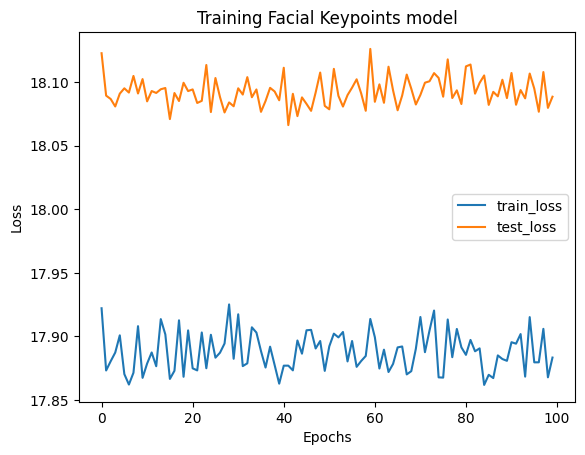

In [33]:
plt.plot(range(epochs), train_epoch, label="train_loss")
plt.plot(range(epochs), val_epoch, label="test_loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Facial Keypoints model")
plt.show()

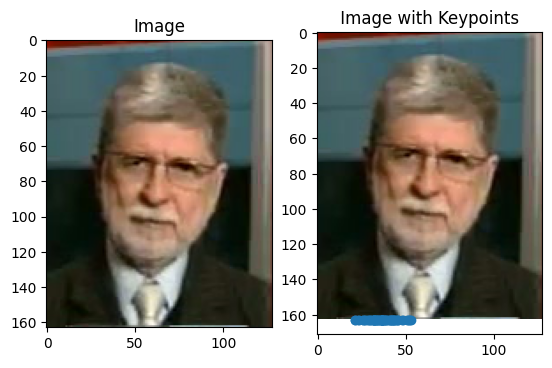

In [34]:
index = 8
test_img, points = test_dataset[index]
Facial_key_points = model(test_img[None]).flatten().detach().cpu()
plt.subplot(121)
plt.title("Image")
img = test_dataset.load_img(index)
img = img[:,:,::-1]
plt.imshow(img)
plt.subplot(122)
plt.title(" Image with Keypoints ")
plt.imshow(img)
plt.scatter(Facial_key_points[:68]*img.shape[1], Facial_key_points[68:]*img.shape[0])                          # scaling the keypoints with image dimension
plt.show()